<a href="https://colab.research.google.com/github/saisumanthpotharla/tourism-sentiment-analysis-atlantic-canada/blob/main/TourSent_Atlantic_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install requests
!pip install vaderSentiment

import requests
import time
import json
import pandas as pd
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Your API Key
API_KEY = 'Your API Key'


In [ ]:
# Coordinates for a list of popular attractions in Atlantic Canada
locations = [
    {'name': 'Peggy\'s Cove Lighthouse', 'coordinates': '44.6365,-63.5491'},
    {'name': 'Cabot Trail', 'coordinates': '46.6828,-60.5931'},
    {'name': 'Fortress of Louisbourg', 'coordinates': '45.8981,-59.9580'},
    {'name': 'Halifax Citadel', 'coordinates': '44.6483,-63.5695'},
    {'name': 'Cape Breton Highlands National Park', 'coordinates': '46.2343,-60.3295'},
    {'name': 'Bay of Fundy', 'coordinates': '45.6593,-64.2957'},
    {'name': 'Hopewell Rocks', 'coordinates': '45.8473,-64.5149'},
    {'name': 'Magnetic Hill', 'coordinates': '46.0597,-64.8045'},
    {'name': 'Fundy National Park', 'coordinates': '45.6991,-64.4660'},
    {'name': 'Kings Landing Historical Settlement', 'coordinates': '45.7265,-66.4878'},
    {'name': 'Green Gables House', 'coordinates': '46.4871,-63.1895'},
    {'name': 'Confederation Bridge', 'coordinates': '46.2186,-63.7984'},
    {'name': 'Prince Edward Island National Park', 'coordinates': '46.4931,-63.2872'},
    {'name': 'Charlottetown Waterfront', 'coordinates': '46.2382,-63.1282'},
    {'name': 'Cavendish Beach', 'coordinates': '46.4874,-63.1951'},
    {'name': 'Gros Morne National Park', 'coordinates': '49.5250,-57.6281'},
    {'name': 'Signal Hill', 'coordinates': '47.5634,-52.7086'},
    {'name': 'L\'Anse aux Meadows', 'coordinates': '51.6000,-55.5875'},
    {'name': 'Cape Spear Lighthouse', 'coordinates': '47.5017,-52.6120'},
    {'name': 'Twillingate', 'coordinates': '49.4370,-54.7660'}
]

In [ ]:

# Define a search radius (in meters)
radius = 5000  # 5 km radius around the attraction

In [ ]:

# Base URLs for Google Places API
places_url = 'https://maps.googleapis.com/maps/api/place/textsearch/json'
details_url = 'https://maps.googleapis.com/maps/api/place/details/json'

In [ ]:
# Function to fetch places data
def get_places_data(query, location, radius):
    params = {
        'query': query,
        'location': location,
        'radius': radius,
        'key': API_KEY
    }
    response = requests.get(places_url, params=params)
    return response.json()

In [ ]:
# Function to fetch reviews for a specific place
def get_place_reviews(place_id):
    params = {
        'place_id': place_id,
        'key': API_KEY,
        'fields': 'name,rating,reviews'
    }
    response = requests.get(details_url, params=params)
    return response.json()

In [ ]:
# Function to gather reviews up to a specified limit
def gather_reviews(place_id, limit=100):
    all_reviews = []
    while len(all_reviews) < limit:
        reviews_data = get_place_reviews(place_id)
        reviews = reviews_data.get('result', {}).get('reviews', [])

        for review in reviews:
            review_info = {
                'text': review.get('text'),
                'time': review.get('time')  # Include time of review
            }
            all_reviews.append(review_info)

        # Check if we have reached the limit or if no more reviews are available
        if not reviews or len(reviews) < 20:
            break
        time.sleep(1)  # Respect API rate limits
    return all_reviews[:limit]  # Return only up to the specified limit

In [ ]:
# Initialize lists to store results
all_attraction_reviews = []
all_accommodation_reviews = []
all_food_reviews = []

In [ ]:
# Loop through each location
for loc in locations:
    location = loc['coordinates']

    # Fetch data for attractions, accommodations, and food
    attractions_data = get_places_data('tourist attractions', location, radius)
    accommodation_data = get_places_data('accommodation', location, radius)
    food_data = get_places_data('restaurants', location, radius)

    # Fetch reviews for attractions
    attraction_reviews = []
    for attraction in attractions_data.get('results', []):
        place_id = attraction['place_id']
        reviews = gather_reviews(place_id, limit=100)  # Ensuring 100 reviews per attraction
        attraction_reviews.append({'name': attraction['name'], 'reviews': reviews})

    all_attraction_reviews.append({'location': loc['name'], 'reviews': attraction_reviews})

    # Fetch reviews for accommodations (limit to 10)
    accommodation_reviews = []
    for accommodation in accommodation_data.get('results', [])[:10]:
        place_id = accommodation['place_id']
        reviews = gather_reviews(place_id, limit=20)
        accommodation_reviews.append({
            'name': accommodation['name'],
            'reviews': reviews,
            'attraction_location': loc['name']
        })

    all_accommodation_reviews.append({'location': loc['name'], 'reviews': accommodation_reviews})

    # Fetch reviews for food places (limit to 20)
    food_reviews = []
    for food_place in food_data.get('results', [])[:20]:
        place_id = food_place['place_id']
        reviews = gather_reviews(place_id, limit=20)
        food_reviews.append({
            'name': food_place['name'],
            'reviews': reviews,
            'attraction_location': loc['name']
        })

    all_food_reviews.append({'location': loc['name'], 'reviews': food_reviews})

    # Add a delay to respect rate limits
    time.sleep(1)

In [ ]:
# Print the number of reviews fetched for each category
print(f"Fetched {sum(len(attraction['reviews']) for attraction in all_attraction_reviews)} attraction reviews.")
print(f"Fetched {sum(len(accommodation['reviews']) for accommodation in all_accommodation_reviews)} accommodation reviews.")
print(f"Fetched {sum(len(food['reviews']) for food in all_food_reviews)} food reviews.")


Fetched 380 attraction reviews.
Fetched 198 accommodation reviews.
Fetched 398 food reviews.


In [ ]:
# Function to flatten review data
def flatten_reviews(review_data, category):
    data = []
    for location_reviews in review_data:
        for review in location_reviews['reviews']:
            for r in review['reviews']:
                data.append({
                    'location': location_reviews['location'],
                    'review_source': review['name'],
                    'review_text': r['text'],
                    'review_time': datetime.fromtimestamp(r['time']),
                    'category': category  # Add category for differentiation
                })
    return pd.DataFrame(data)

In [ ]:
# Flatten data for each category
attraction_df = flatten_reviews(all_attraction_reviews, 'Attraction')
accommodation_df = flatten_reviews(all_accommodation_reviews, 'Accommodation')
food_df = flatten_reviews(all_food_reviews, 'Food')

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
# Function to preprocess and analyze sentiment
def preprocess_and_analyze_sentiment(df):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Cleaning the review text
    def preprocess_review(text):
        tokens = word_tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
        return ' '.join(tokens)

    # Apply cleaning function
    df['cleaned_review'] = df['review_text'].apply(preprocess_review)

    # Apply sentiment analysis
    df['sentiment_score'] = df['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

    return df

In [ ]:
# Assume you have separate DataFrames for attraction, food, and accommodation reviews
# Each DataFrame contains a 'review_text' column
# Replace with your actual DataFrame names
attraction_df = preprocess_and_analyze_sentiment(attraction_df)
food_df = preprocess_and_analyze_sentiment(food_df)
accommodation_df = preprocess_and_analyze_sentiment(accommodation_df)

In [ ]:
# Add a category column to each DataFrame to track where the reviews come from
attraction_df['category'] = 'Attraction'
food_df['category'] = 'Food'
accommodation_df['category'] = 'Accommodation'

In [ ]:
# Combine the dataframes
combined_df = pd.concat([attraction_df, food_df, accommodation_df], ignore_index=True)

# Ensure necessary columns are present
combined_df['cleaned_review'] = combined_df['cleaned_review'].fillna('')
combined_df['category'] = combined_df['category'].fillna('Unknown')

In [ ]:
# Group by location and calculate the mean sentiment score for each category
sentiment_by_location = combined_df.groupby(['location', 'category'])['sentiment_score'].mean().unstack()

# Correlation analysis between the sentiment scores for Food, Accommodation, and Attraction
correlation_matrix = sentiment_by_location[['Food', 'Accommodation', 'Attraction']].corr()

# Display correlation matrix
print("Correlation between Food, Accommodation, and Attraction Sentiment Scores:")
print(correlation_matrix)

Correlation between Food, Accommodation, and Attraction Sentiment Scores:
category           Food  Accommodation  Attraction
category                                          
Food           1.000000       0.000960    0.161079
Accommodation  0.000960       1.000000    0.021525
Attraction     0.161079       0.021525    1.000000


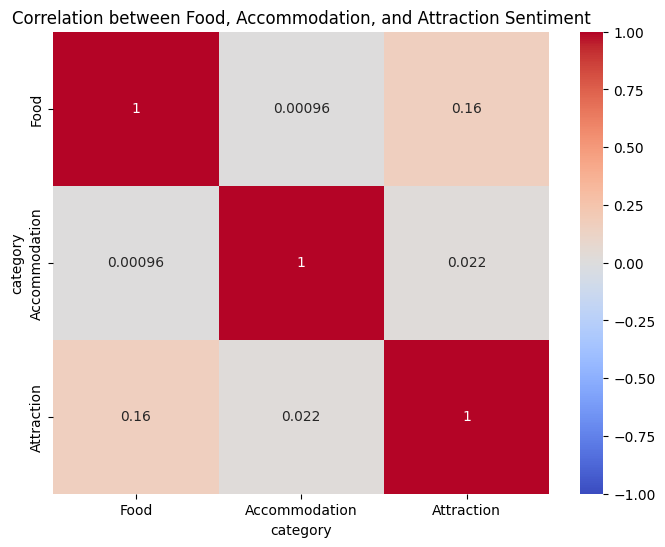

In [ ]:
# Plotting correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Food, Accommodation, and Attraction Sentiment')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_keywords(df, n=10):
    # Create a CountVectorizer to count word occurrences
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_review'])

    # Sum up the counts of each vocabulary word
    word_counts = X.toarray().sum(axis=0)

    # Create a DataFrame of words and their counts
    keywords = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts})

    # Sort by count and return the top n words
    return keywords.sort_values(by='count', ascending=False).head(n)

# Get top keywords for each category
attraction_keywords = get_top_keywords(attraction_df)
accommodation_keywords = get_top_keywords(accommodation_df)
food_keywords = get_top_keywords(food_df)

print("Top Keywords in Attraction Reviews:")
print(attraction_keywords)

print("\nTop Keywords in Accommodation Reviews:")
print(accommodation_keywords)

print("\nTop Keywords in Food Reviews:")
print(food_keywords)


Top Keywords in Attraction Reviews:
           word  count
2548      place    420
2450       park    418
356   beautiful    371
1536      great    350
3704       view    332
2313       nice    288
3545      trail    268
3717      visit    263
3496       time    231
2061        lot    225

Top Keywords in Accommodation Reviews:
           word  count
3335       room    764
3776       stay    568
1749      great    449
761       clean    364
515   breakfast    355
2900      place    351
942     cottage    305
1929      hotel    287
2308   location    265
2629       nice    260

Top Keywords in Food Reviews:
            word  count
1982        food   1384
2158        good    864
2203       great    792
4332     service    693
3642       place    605
4068  restaurant    545
4996        time    469
1382   delicious    419
4638       staff    403
2039    friendly    385
